In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_decomposition import PLSRegression

from nirs4all.operators.transformations import Gaussian, SavitzkyGolay, StandardNormalVariate, Haar, MultiplicativeScatterCorrection
from nirs4all.pipeline.config import PipelineConfigs
from nirs4all.dataset.dataset_config import DatasetConfigs
from nirs4all.pipeline.runner import PipelineRunner
import json

# pipeline_separated = [
#     MinMaxScaler(feature_range=(0.1, 0.8)),
#     {
#         "feature_augmentation": {
#             "_or_": [Gaussian, StandardNormalVariate, SavitzkyGolay, Haar],
#             "size": [3, (1,2)],
#             "count": 2,
#         }
#     },
#     ShuffleSplit(n_splits=3),
#     {"y_processing": MinMaxScaler},
#     {
#         "model": PLSRegression,
#         "model_params": {
#             "n_components": {
#                 "_range_": [10, 30, 2],
#             }
#         }
#     }
# ]

### TODO - Variables qui reprennent des noms simples
### TODO - Exposer les arguments des dataconfigs (separator, delimiter, etc.)
### TODO - Pouvoir charger le dataset automatiquement (sans passer par la config)

pipeline = [
    # Normalize the spectra reflectance
    MinMaxScaler(),
    # Normalize the y values
    {"y_processing": MinMaxScaler()},

    # Generate 10 version of feature augmentation combinations (3 elements with size 1 to 2, ie. [SG, [SNV, GS], Haar])
    {
        "feature_augmentation": {
            "_or_": [
                Gaussian, StandardNormalVariate, SavitzkyGolay, Haar, MultiplicativeScatterCorrection #TODO ajouter des prétraitements
            ],
            "size":[1,(1,2)],
        }
    },

    # Split the dataset in train and validation
    ShuffleSplit(n_splits=3, test_size=.25),
]

for i in range(10, 30, 2):
    pipeline.append(PLSRegression(n_components=i))

# create pipeline config
p_config = PipelineConfigs(pipeline, "Question_1")

# # path = ['../../sample_data/regression', '../../sample_data/classification', '../../sample_data/binary']
folder = '../../sample_data/regression'
d_config = DatasetConfigs(folder)
runner = PipelineRunner(save_files=False)
predictions, results = runner.run(p_config, d_config)
# result = (global_predictions, run_predictions) per dataset

✅ Loaded pipeline(s) with 25 configuration(s).
📥 Loaded 750 predictions from results\regression\regression_predictions.json
🚀 Starting pipeline config_Question_1_5f21ed on dataset regression
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
🔷 Step 1: {'class': 'sklearn.preprocessing._data.MinMaxScaler', '_runtime_instance': MinMaxScaler()}
🔹 Executing controller TransformerMixinController with operator MinMaxScaler
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
🔷 Step 2: {'y_processing': {'class': 'sklearn.preprocessing._data.MinMaxScaler', '_runtime_instance': MinMaxScaler()}}
🔹 Executing controller YTransformerMixinController with operator MinMaxScaler
--------------------------------

1. PLSRegression_5 (partition: test_fold_0) - RMSE: 11.722480, R²: 0.782105, MAE: 9.218973
results\regression\config_Question_1_b78bc0
2. PLSRegression_28 (partition: test_fold_2) - RMSE: 11.742454, R²: 0.781664, MAE: 9.693986
results\regression\config_Question_1_8d4fda
3. PLSRegression_23 (partition: test_fold_0) - RMSE: 11.963357, R²: 0.773058, MAE: 10.108297
results\regression\config_Question_1_b78bc0
4. PLSRegression_14 (partition: test_fold_0) - RMSE: 11.973082, R²: 0.772689, MAE: 9.795067
results\regression\config_Question_1_b78bc0
5. PLSRegression_19 (partition: test_fold_2) - RMSE: 11.993090, R²: 0.772244, MAE: 9.746035
results\regression\config_Question_1_8d4fda
🔍 COMPREHENSIVE PREDICTION SUMMARY

📊 Dataset: regression
────────────────────────────────────────

  🔧 Pipeline: config_Question_1_5f21ed
  ───────────────────────────────────

    🤖 Base Model: PLSRegression
    ──────────────────────────────

      📈 Fold Test:
        ✅ 30 instances:
          Instance 0: 33 sample

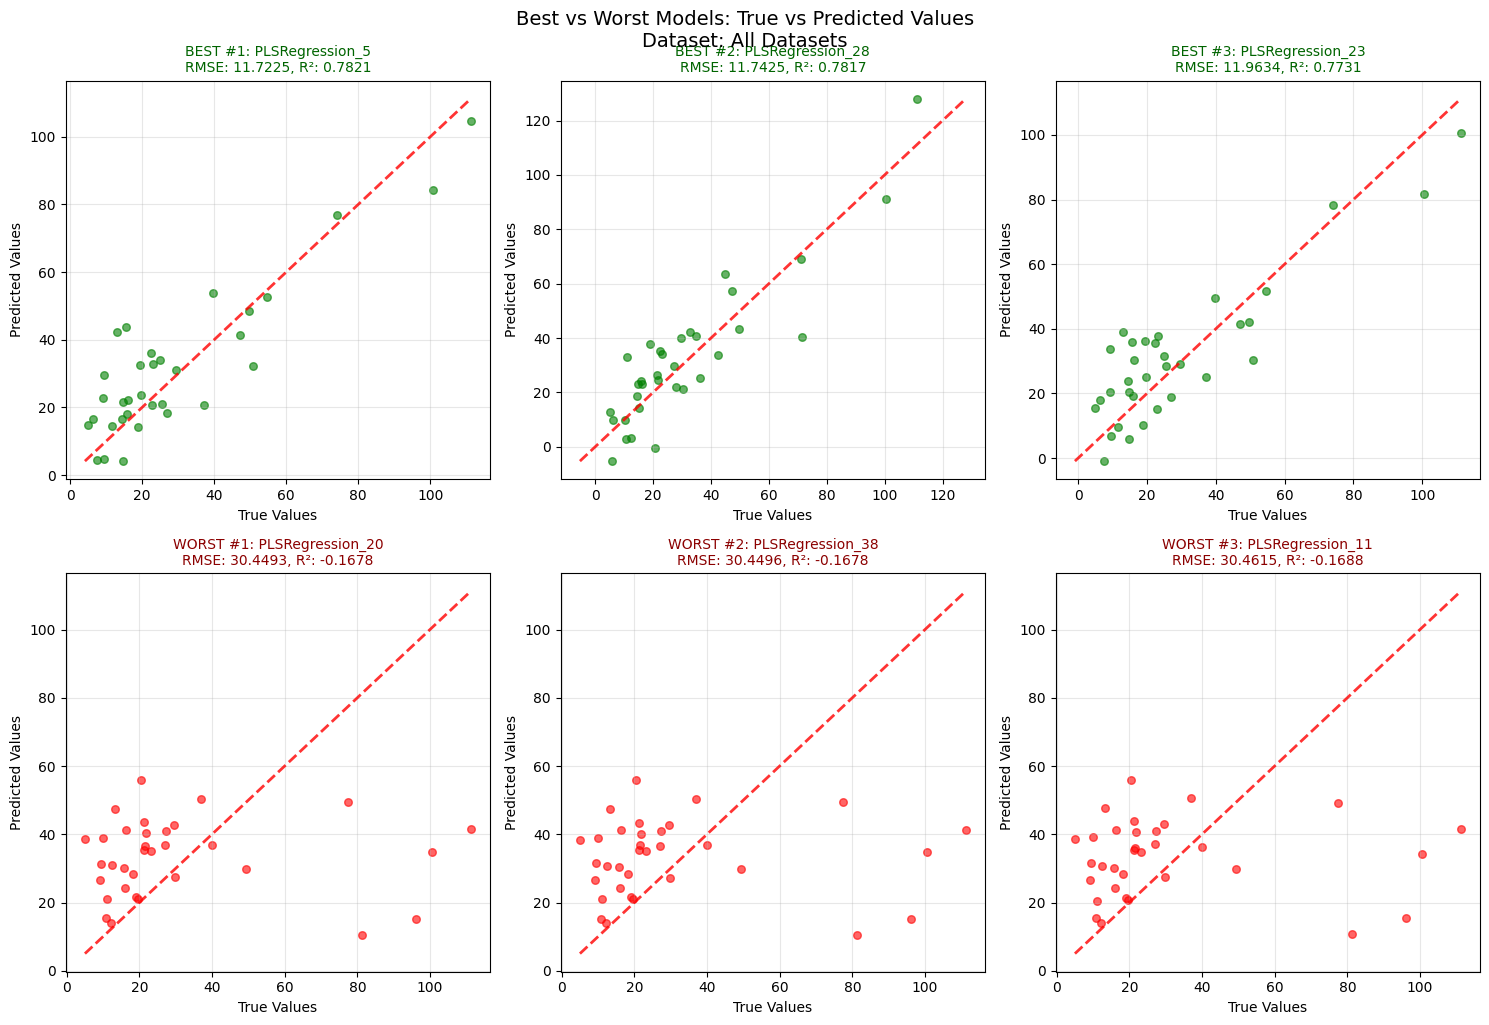

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from nirs4all.dataset.prediction_visualizer import PredictionVisualizer

visualizer = PredictionVisualizer(predictions)

top_5 = visualizer.get_top_k(5, 'rmse')
for i, model in enumerate(top_5, 1):
    print(f"{i}. {model['model']} (partition: {model['partition']}) - RMSE: {model['rmse']:.6f}, R²: {model['r2']:.6f}, MAE: {model['mae']:.6f}")
    print(model['path'])


print(visualizer.comprehensive_prediction_summary())
#### Plot Predit observe + résidu
fig = visualizer.plot_best_worst_models_comparison(
    metric='rmse',
    n_best=3,
    n_worst=3,
    figsize=(15,10)
)
plt.show()
